In [1]:
!pip install POT

In [1]:
import ot

In [2]:
import numpy as np
import scipy
import math
import random
from collections import defaultdict
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
import random
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as torch_data
from nilearn import plotting
import nibabel as nib
import nilearn
import os
import sys
import pathlib
import functools
from sklearn.model_selection import train_test_split, StratifiedKFold
from torchvision.transforms import *
import time
import pandas as pd

In [4]:
sys.path.insert(0,'/home')
from data import HCP_MRI_reshape

In [5]:
import nilearn
from nilearn import plotting
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
data_dir = pathlib.Path('/data/adni')

In [7]:
def plot_central_cuts(img, title="", t=None):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    param image: tensor or np array of shape (TxCxDxHxW) if t is not None
    """
    if t is not None:
        img = img[t]
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 6, 6))
    fig.suptitle(title)
    axes[0].imshow(img[0, img.shape[1] // 2, :, :])
    axes[1].imshow(img[0, :, img.shape[2] // 2, :])
    axes[2].imshow(img[0, :, :, img.shape[3] // 2])
    plt.show()
# plot_central_cuts(nilearn.image.get_data(img)[np.newaxis,:], title="ex", t = None)
# plot_central_cuts(img_crop, title="ex", t = None)

In [8]:
# PATH_TO_MRI = '/data/hcp/HCP_T1_pm'
data_dir = pathlib.Path('/data/adni')
behavioral_path = os.path.join('/data/adni', 'unrestricted_hcp_freesurfer.csv')
hcp_type = 'MPR1'
PATH_TO_MRI = '/home/crop_data_resize'

In [9]:
df = pd.read_csv(behavioral_path)

In [10]:
df_M = df.loc[df["Gender"]=='M']
df_F = df.loc[df["Gender"]=='F']

In [11]:
len(df_M), len(df_F)

(507, 606)

In [12]:
df_M['FS_InterCranial_Vol'].shape, df_F['FS_InterCranial_Vol'].shape

((507,), (606,))

In [13]:
df_M['FS_InterCranial_Vol'].values.reshape(-1,1).shape, df_F['FS_InterCranial_Vol'].values.reshape(-1,1).shape

((507, 1), (606, 1))

In [14]:
# norm_M = preprocessing.normalize(df_M['FS_InterCranial_Vol'].values.reshape(-1, 1))
# norm_F = preprocessing.normalize(df_F['FS_InterCranial_Vol'].values.reshape(-1, 1))

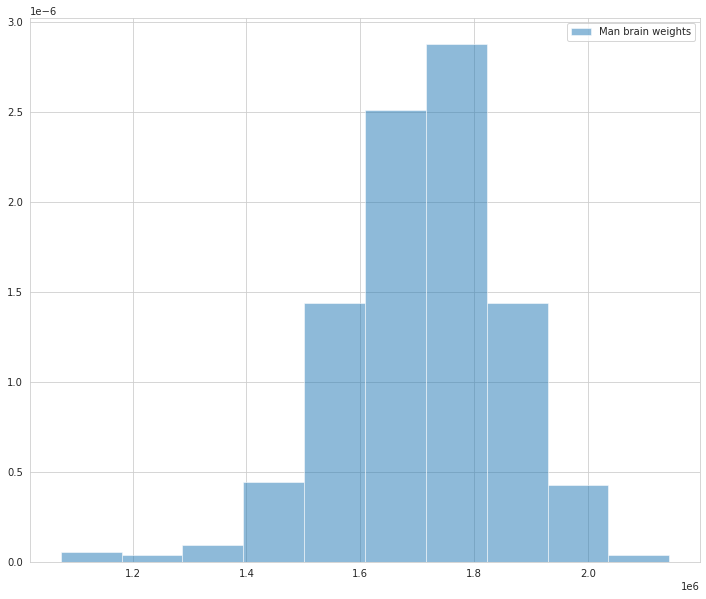

In [15]:
fig = plt.figure(figsize=(12,10))
plt.hist(df_M['FS_InterCranial_Vol'].values.reshape(-1, 1), label="Man brain weights", alpha=0.5, density=True);
plt.legend()
plt.show()

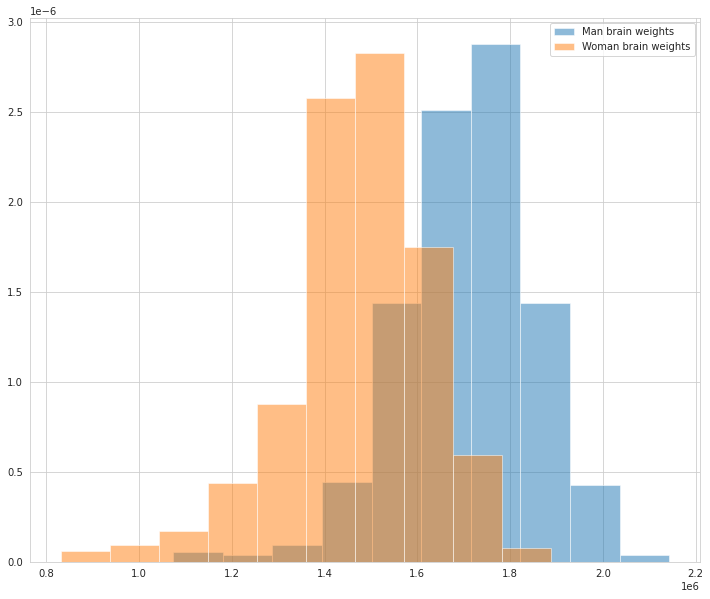

In [16]:
fig = plt.figure(figsize=(12,10))
plt.hist(df_M['FS_InterCranial_Vol'].values.reshape(-1, 1), label="Man brain weights", alpha=0.5, density=True);
plt.hist(df_F['FS_InterCranial_Vol'].values.reshape(-1, 1), label="Woman brain weights", alpha=0.5, density=True);
plt.legend()
plt.show()

# Mean correction

In [17]:
man_brains_weight = df_M['FS_InterCranial_Vol'].values.reshape(-1, 1)
woman_brains_weight = df_F['FS_InterCranial_Vol'].values.reshape(-1, 1)
mean = (man_brains_weight.sum() + woman_brains_weight.sum()) / (len(man_brains_weight) + len(woman_brains_weight))
man_brains_weight = man_brains_weight - man_brains_weight.mean() + mean
woman_brains_weight = woman_brains_weight - woman_brains_weight.mean() + mean

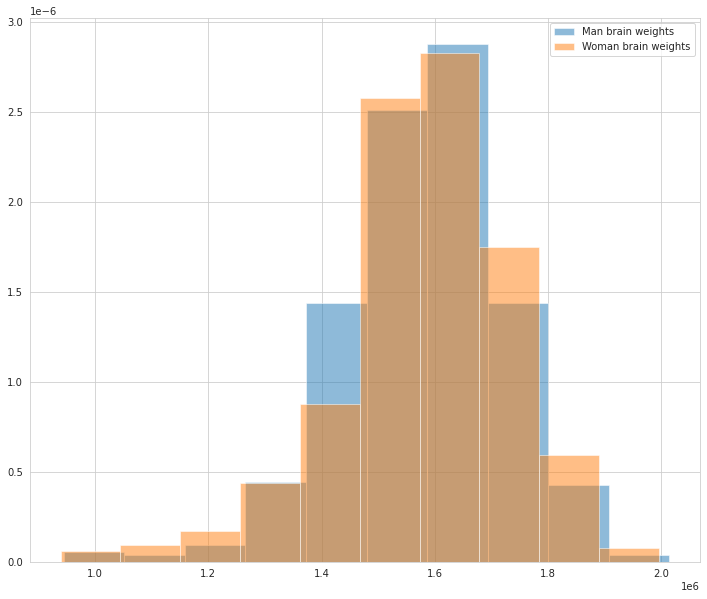

In [18]:
fig = plt.figure(figsize=(12,10))
plt.hist(man_brains_weight, label="Man brain weights", alpha=0.5, density=True);
plt.hist(woman_brains_weight, label="Woman brain weights", alpha=0.5, density=True);
plt.legend()
plt.show()

# Optimal Transport


In [19]:
man_brains_weight.shape, woman_brains_weight.shape

((507, 1), (606, 1))

In [20]:
# EMD Transport
ot_emd = ot.da.EMDTransport()
ot_emd.fit(Xs=man_brains_weight, Xt=woman_brains_weight)

# Sinkhorn Transport
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)
ot_sinkhorn.fit(Xs=man_brains_weight, Xt=woman_brains_weight)

# transport source samples onto target samples
man_brains_weight_emd = ot_emd.transform(Xs=man_brains_weight)
man_brains_weight_sinkhorn = ot_sinkhorn.transform(Xs=man_brains_weight)

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/ot/bregman.py:363: RuntimeWarning: divide by zero encountered in true_divide
  v = np.divide(b, KtransposeU)
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/ot/bregman.py:363: RuntimeWarning: overflow encountered in true_divide
  v = np.divide(b, KtransposeU)
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/ot/da.py:1048: RuntimeWarning: invalid value encountered in true_divide
  transp = self.coupling_ / np.sum(self.coupling_, 1)[:, None]


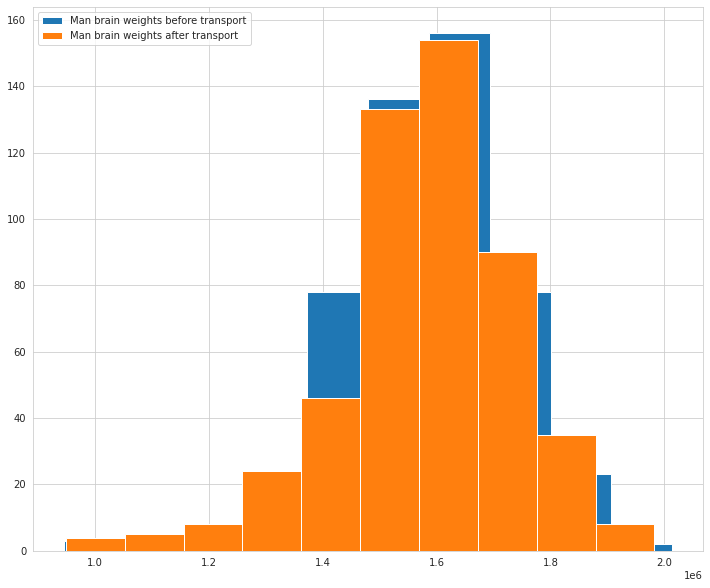

In [21]:
fig = plt.figure(figsize=(12,10))
plt.hist(man_brains_weight, label="Man brain weights before transport");
plt.hist(man_brains_weight_emd, label="Man brain weights after transport");
plt.legend()
plt.show()

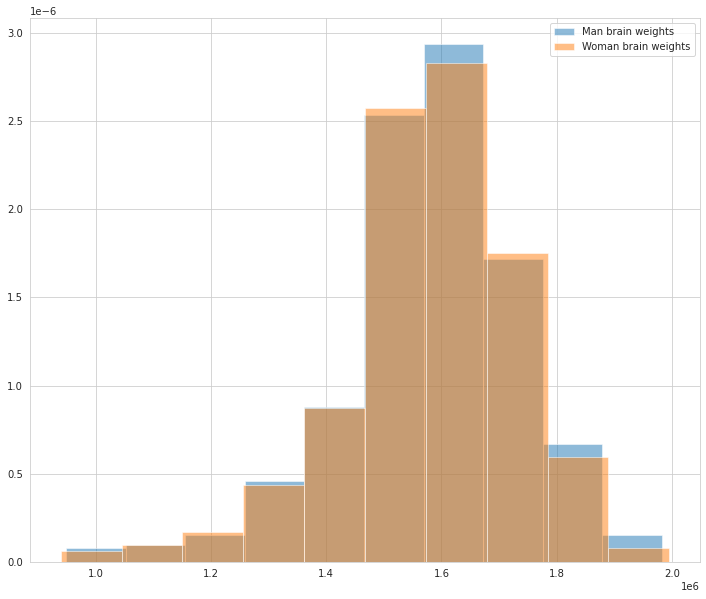

In [22]:
fig = plt.figure(figsize=(12,10))
plt.hist(man_brains_weight_emd, label="Man brain weights", alpha=0.5, density=True);
plt.hist(woman_brains_weight, label="Woman brain weights", alpha=0.5, density=True);
plt.legend()
plt.show()

In [23]:
shift = man_brains_weight_emd - man_brains_weight

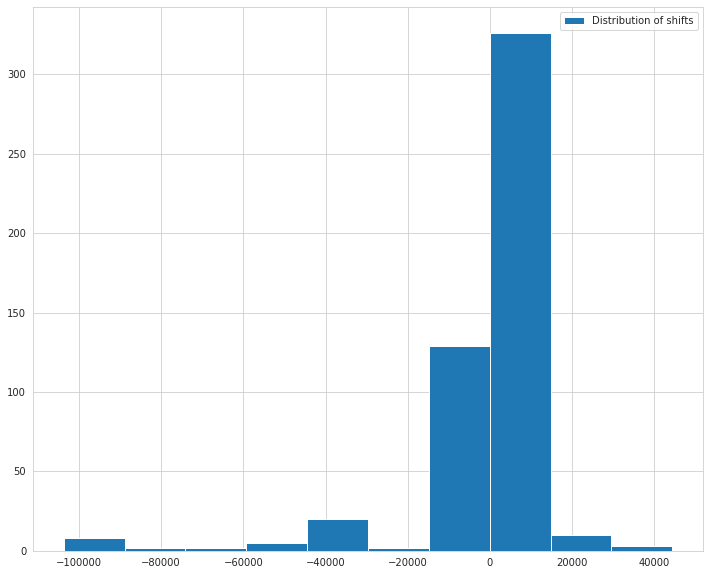

In [24]:
fig = plt.figure(figsize=(12,10))
plt.hist(shift.reshape(-1), label="Distribution of shifts");
plt.legend()

In [25]:
shift

array([[ 2.85634708e+03],
       [-2.67616757e+03],
       [ 9.20021024e+03],
       [-2.83351512e+04],
       [ 9.20136955e+03],
       [ 7.12922810e+03],
       [-4.93828004e+02],
       [-3.45991322e+03],
       [-1.68299765e+03],
       [ 1.43632922e+03],
       [ 1.31239547e+04],
       [-1.79064969e+03],
       [ 6.40674763e+03],
       [ 1.17474570e+04],
       [-1.15308804e+03],
       [ 4.85275575e+03],
       [ 5.92174869e+03],
       [ 3.97258446e+03],
       [ 1.27353089e+04],
       [ 1.40116914e+03],
       [ 1.98664670e+02],
       [ 9.00673298e+03],
       [-6.95532400e+01],
       [ 8.14776778e+03],
       [ 8.42552373e+03],
       [ 9.90281952e+03],
       [-4.36494099e+02],
       [ 4.98289726e+02],
       [-2.73737178e+03],
       [ 2.14713847e+04],
       [ 8.58314655e+03],
       [ 2.67973177e+03],
       [ 7.13645264e+03],
       [ 4.45240910e+03],
       [ 1.29400968e+04],
       [ 7.52601222e+03],
       [-2.30375934e+03],
       [ 5.03622636e+02],
       [-2.6

In [27]:
min(shift), max(shift)

(array([-103726.88929233]), array([44399.23125291]))

In [28]:
amax = np.max(shift)
amin = np.min(shift)
rang = amax-amin
norm_shift = ((shift - amin)/rang)

In [30]:
min(norm_shift), max(norm_shift)

(array([0.]), array([1.]))

In [29]:
norm_shift

array([[0.71954383],
       [0.6821938 ],
       [0.76237128],
       [0.50896991],
       [0.7623791 ],
       [0.74839007],
       [0.69692679],
       [0.67690273],
       [0.6888987 ],
       [0.70995729],
       [0.78886049],
       [0.68817194],
       [0.7435126 ],
       [0.77956775],
       [0.69247612],
       [0.73302159],
       [0.74023837],
       [0.72707955],
       [0.78623674],
       [0.70971992],
       [0.70160181],
       [0.76106511],
       [0.69979107],
       [0.75526623],
       [0.75714136],
       [0.76711459],
       [0.69731385],
       [0.70362458],
       [0.68178061],
       [0.84521402],
       [0.75820548],
       [0.7183515 ],
       [0.74843884],
       [0.73031885],
       [0.78761926],
       [0.75106876],
       [0.68470793],
       [0.70366058],
       [0.68249541],
       [0.746889  ],
       [0.77078196],
       [0.77730992],
       [0.69511421],
       [0.74863187],
       [0.69486882],
       [0.76509907],
       [0.74922204],
       [0.761

In [26]:
scale =  man_brains_weight/man_brains_weight_emd

In [27]:
min(scale), max(scale)

(array([0.956145]), array([1.0883025]))

In [29]:
np.save('/home/scale', scale)

In [28]:
scale

array([[0.99835688],
       [1.00172385],
       [0.99457611],
       [1.02090558],
       [0.99352303],
       [0.99581164],
       [1.00031949],
       [1.00215631],
       [1.00104715],
       [0.99913982],
       [0.99255285],
       [1.0011363 ],
       [0.99620198],
       [0.99195991],
       [1.00073083],
       [0.99734942],
       [0.9960603 ],
       [0.99772807],
       [0.99110473],
       [0.9991317 ],
       [0.99987812],
       [0.99377178],
       [1.00004217],
       [0.99527821],
       [0.99503921],
       [0.99332014],
       [1.00026473],
       [0.9997009 ],
       [1.00173273],
       [0.98861363],
       [0.99494942],
       [0.99834694],
       [0.9960459 ],
       [0.99706334],
       [0.99114196],
       [0.99508096],
       [1.00149512],
       [0.99968716],
       [1.0016408 ],
       [0.99549206],
       [0.9929202 ],
       [0.99341411],
       [1.0004645 ],
       [0.99525802],
       [1.00048278],
       [0.99354033],
       [0.9949454 ],
       [0.994

In [35]:
df['FS_InterCranial_Vol']
amax = np.max(df['FS_InterCranial_Vol'])
amin = np.min(df['FS_InterCranial_Vol'])
rang = amax-amin
norm_shift = ((df['FS_InterCranial_Vol'] - amin)/rang)*2

In [36]:
norm_shift

0       1.575185
1       1.038627
2       1.300180
3       1.501290
4       0.924796
          ...   
1108    1.048500
1109    0.879568
1110    1.382339
1111    1.393552
1112    1.467537
Name: FS_InterCranial_Vol, Length: 1113, dtype: float64

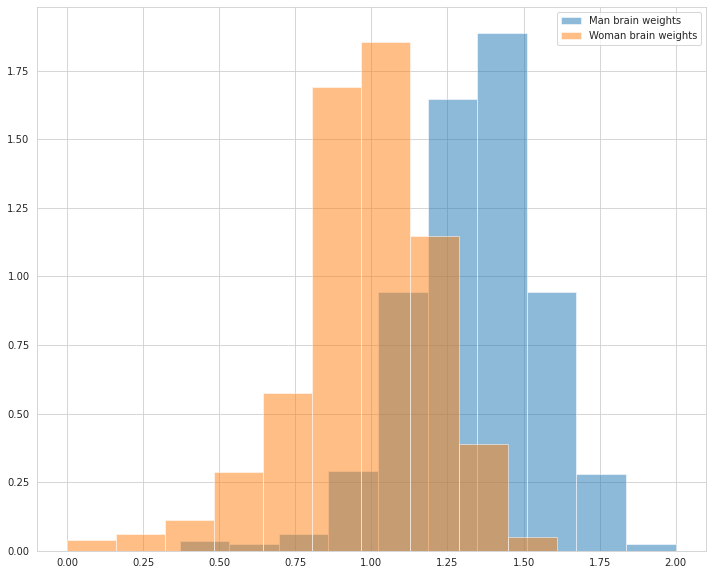

In [37]:
df_M = norm_shift.loc[df["Gender"]=='M']
df_F = norm_shift.loc[df["Gender"]=='F']
fig = plt.figure(figsize=(12,10))
plt.hist(df_M.values.reshape(-1, 1), label="Man brain weights", alpha=0.5, density=True);
plt.hist(df_F.values.reshape(-1, 1), label="Woman brain weights", alpha=0.5, density=True);
plt.legend()
plt.show()

In [38]:
man_brains_weight = df_M.values.reshape(-1, 1)
woman_brains_weight = df_F.values.reshape(-1, 1)
mean = (man_brains_weight.sum() + woman_brains_weight.sum()) / (len(man_brains_weight) + len(woman_brains_weight))
man_brains_weight = man_brains_weight - man_brains_weight.mean() + mean
woman_brains_weight = woman_brains_weight - woman_brains_weight.mean() + mean

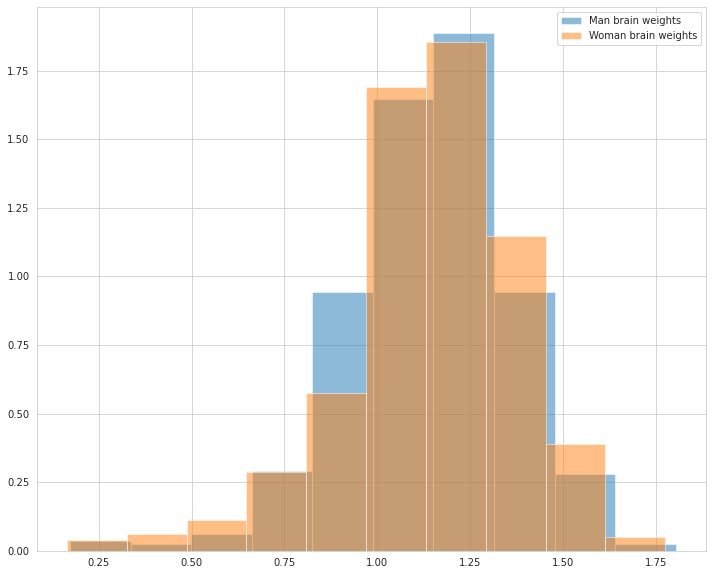

In [39]:
fig = plt.figure(figsize=(12,10))
plt.hist(man_brains_weight, label="Man brain weights", alpha=0.5, density=True);
plt.hist(woman_brains_weight, label="Woman brain weights", alpha=0.5, density=True);
plt.legend()
plt.show()

In [40]:
# EMD Transport
ot_emd = ot.da.EMDTransport()
ot_emd.fit(Xs=man_brains_weight, Xt=woman_brains_weight)

# Sinkhorn Transport
ot_sinkhorn = ot.da.SinkhornTransport(reg_e=1e-1)
ot_sinkhorn.fit(Xs=man_brains_weight, Xt=woman_brains_weight)

# transport source samples onto target samples
man_brains_weight_emd = ot_emd.transform(Xs=man_brains_weight)
man_brains_weight_sinkhorn = ot_sinkhorn.transform(Xs=man_brains_weight)

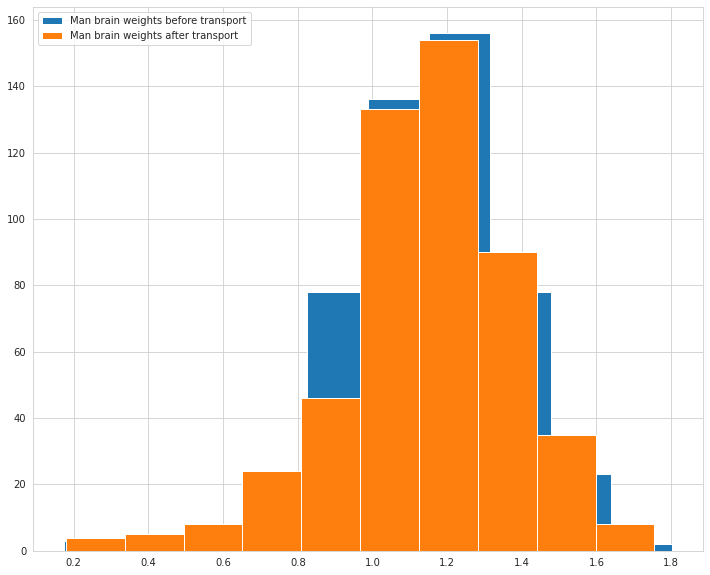

In [41]:
fig = plt.figure(figsize=(12,10))
plt.hist(man_brains_weight, label="Man brain weights before transport");
plt.hist(man_brains_weight_emd, label="Man brain weights after transport");
plt.legend()
plt.show()

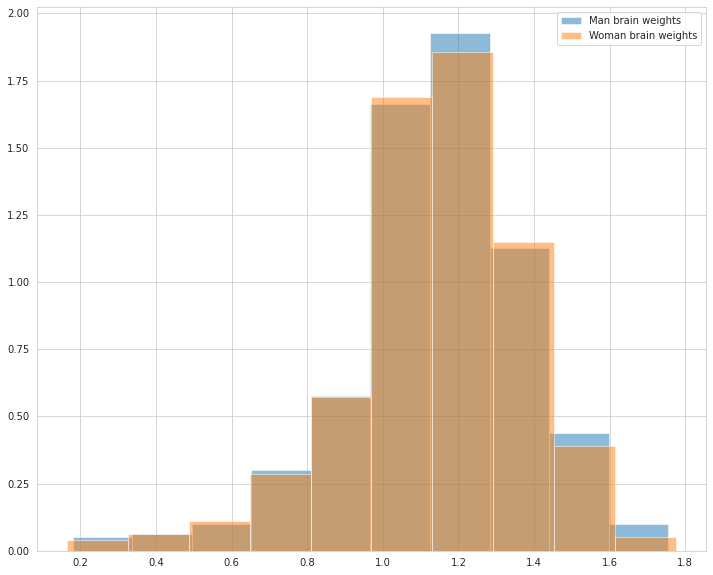

In [42]:
fig = plt.figure(figsize=(12,10))
plt.hist(man_brains_weight_emd, label="Man brain weights", alpha=0.5, density=True);
plt.hist(woman_brains_weight, label="Woman brain weights", alpha=0.5, density=True);
plt.legend()
plt.show()

In [43]:
shift = man_brains_weight_emd - man_brains_weight

In [44]:
scale = man_brains_weight/man_brains_weight_emd

In [45]:
min(scale), max(scale)

(array([0.75497308]), array([1.35092625]))

In [46]:
scale

array([[0.99685134],
       [1.00371057],
       [0.9893643 ],
       [1.05405627],
       [0.98438914],
       [0.99181437],
       [1.0006912 ],
       [1.00447396],
       [1.00216879],
       [0.99828722],
       [0.98590446],
       [1.00240469],
       [0.99251249],
       [0.98135033],
       [1.00154452],
       [0.9951454 ],
       [0.9911864 ],
       [0.99566948],
       [0.97879168],
       [0.99820935],
       [0.99975131],
       [0.98535274],
       [1.00008501],
       [0.99088981],
       [0.99028439],
       [0.98479487],
       [1.00053385],
       [0.99940305],
       [1.00365667],
       [0.97963833],
       [0.9901142 ],
       [0.99660736],
       [0.99267016],
       [0.99349954],
       [0.97944782],
       [0.98922957],
       [1.00324638],
       [0.99935318],
       [1.00340613],
       [0.99014641],
       [0.98378607],
       [0.98734337],
       [1.00094119],
       [0.98945964],
       [1.00097033],
       [0.98535032],
       [0.98798497],
       [0.989

In [47]:
np.save('/home/normilized_scale', scale)